## How to generate pulsar frequencies :: residuals method


This notebook follows on from `01.explore_how_to_generate_frequencies.ipynb`


In the original notebook we had some trouble accounting for the barycentering corrections.


This notebook circumvents this issue by working with the timing model residuals. 





## 1. Imports and setup

As in `01.explore_how_to_generate_frequencies.ipynb`...


In [1]:
import os 
os.environ['TEMPO2'] = '/fred/oz022/tkimpson/tempo2/T2runtime' # set the environment variable
import libstempo

## 2. Generating TOAs

Again, lets look at how to generate some TOAs using our data files + `libstempo`


In [2]:
# First define the data to use
import glob
path_to_data = '../mdc/IPTA_Challenge1_open/Challenge_Data/Dataset1/'
list_of_par_files = sorted(glob.glob(path_to_data+'/*.par'))
list_of_tim_files = sorted(glob.glob(path_to_data+'/*.tim'))
assert len(list_of_par_files) == len(list_of_tim_files)

In [3]:
#Pick a particular pulsar
psr_idx = 0
par_file = list_of_par_files[psr_idx]
tim_file = list_of_tim_files[psr_idx]

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 


/tmp/ipykernel_1515199/2615926483.py:2: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)


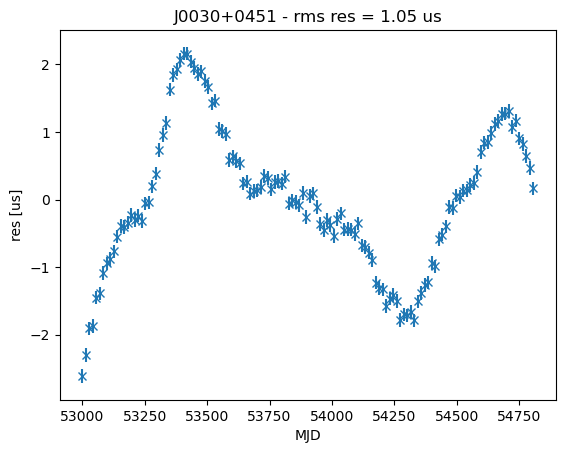

In [4]:
#Generate a tempopulsar object 
psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)

import libstempo.plot
#Plot it 
libstempo.plot.plotres(psr)

Now lets correct the TOAs given our timing model 

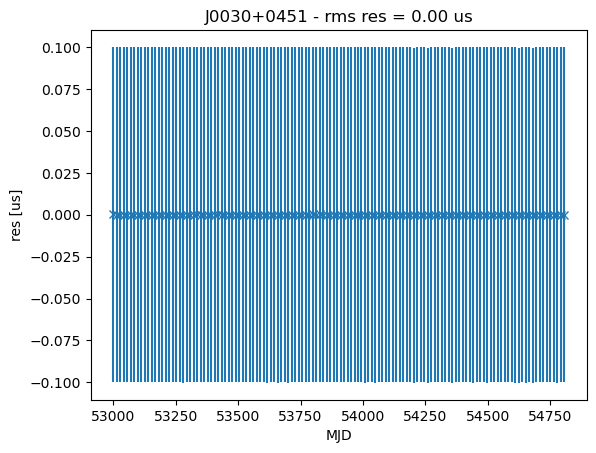

In [5]:
import libstempo.toasim as toasim
toasim.make_ideal(psr) # make_ideal shifts the ToAs so that they are exactly aligned with the timing model we loaded
toasim.make_ideal(psr) # For whatever reason doing two passes of make_ideal gets a better result - with just one you can end up with a slight trend in the residuals
libstempo.plot.plotres(psr)


i.e. zero residuals with some error bars. This makes sense because the TOAs were generated via the timing model and so agree exactly.


## 3. Adding noise 


Now lets add some noise to these TOAs. We are interested in 3 different types:

* White noise (i.e. measurement noise)
* Red noise (uncorrelated between PSRs) i.e. intrinstic pulsar spin noise 
* Red noise (correlated between PSRs) i.e. the stochastic GW background 

We use libstempo to add thees noises. See https://github.com/vallis/libstempo/blob/master/libstempo/toasim.py

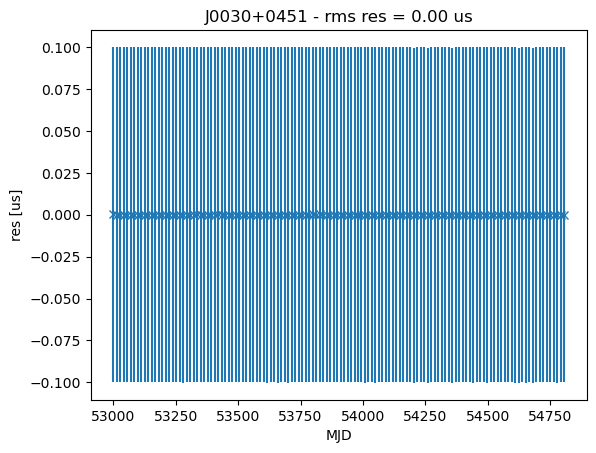

In [6]:
#Parameters

## Random seeding
noise_seed = 1

## GW parameters
alpha=-2/3 # this is defined as being negative
gw_amplitude = 0.0 #5e-14

## Red noise parameters
gamma = 4 #...this is positive
A = 0.0#1e-12


## White noise parameters
### to do. One can define an efac parameter to scale the errors to be what you want. For now, lets just leave them as in the .tim file 
efac = 0.0

## Now add noise 
toasim.add_rednoise(psr,A, gamma,seed=noise_seed)                    # Add some red noise 
toasim.add_efac(psr,seed=noise_seed,efac=efac)                                 # Add white noise at the level specified in the .tim file
toasim.add_gwb(psr,seed=noise_seed, gwAmp=gw_amplitude, alpha=alpha) # add GW backgriund given an amplitude and an index


libstempo.plot.plotres(psr)






## 4. Generating frequencies


Given these TOAs that are perturbed by different noise processes, we want to obtain a frequency timeseries $f(t)$ to be ingested by the Kalman filter.


Previously we used $$f(t) = \frac{\Delta \phi}{\Delta t}=\frac{\phi(t_{i+1}) - \phi({t_i})}{t_{i+1} - t_{i}}$$


We can do something similar here as follows

$$\text{residual}(t) = \phi(t) - \phi_{\rm TM}(t)$$


where $\phi_{\rm TM}(t)$ is the phase evolution given the timing model 

$$f(t) = \frac{\text{residual}(t_{i+1})-\text{residual}(t_{i})}{t_{i+1} - t_{i}}$$

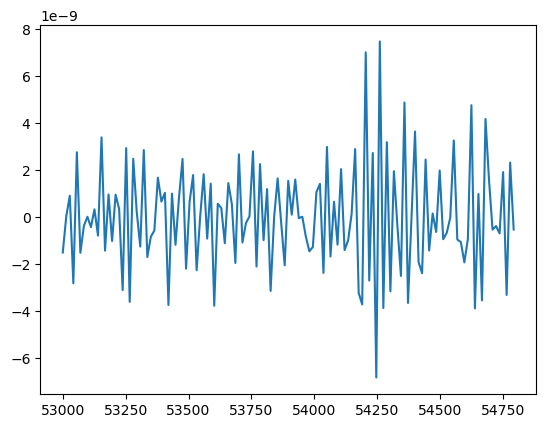

In [7]:
import matplotlib.pyplot as plt 
import numpy as np 

residuals  = psr.residuals()       # units of seconds
pulsar_emission_times = psr.pets() # PET for Pulsar Emission Time - these are the ToAs in the pulsar frame. PETs are in MJD so multiply by 86400 to get seconds

dt = np.diff(pulsar_emission_times)
dres = np.diff(residuals)

f = dres/dt 
f_Hz = f*psr['F0'].val # F0 factor for units 

#Consider the frequencies to be evaluated at the lower end of the box - arbitrary
t_eval = pulsar_emission_times[0:-1]

plt.plot(t_eval,f_Hz)
